In [ ]:
!unzip /content/MildDemented.zip
!unzip /content/ModerateDemented.zip
!unzip /content/NonDemented.zip
!unzip /content/VeryMildDemented.zip

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

2024-11-07 14:13:28.438057: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 14:13:28.493287: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU is available and enabled for TensorFlow
Found 19030 validated image filenames belonging to 4 classes.
Found 4758 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.


2024-11-07 14:13:30.935772: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77872 MB memory:  -> device: 0, name: NVIDIA H100 PCIe, pci bus id: 0000:2a:00.0, compute capability: 9.0


Epoch 1/25


2024-11-07 14:13:42.778996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-11-07 14:13:43.135696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-07 14:13:44.696420: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f972e9a8e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-07 14:13:44.696496: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA H100 PCIe, Compute Capability 9.0
2024-11-07 14:13:44.708591: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-07 14:13:44.911139: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

149/149 [==============================] - 229s 1s/step - loss: 0.9079 - accuracy: 0.6321 - val_loss: 0.8851 - val_accuracy: 0.6303 - lr: 0.0010
Epoch 2/25
149/149 [==============================] - 235s 2s/step - loss: 0.6286 - accuracy: 0.7275 - val_loss: 0.6640 - val_accuracy: 0.7524 - lr: 0.0010
Epoch 3/25
149/149 [==============================] - 186s 1s/step - loss: 0.5536 - accuracy: 0.7585 - val_loss: 0.5416 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 4/25
149/149 [==============================] - 240s 2s/step - loss: 0.5061 - accuracy: 0.7838 - val_loss: 0.4526 - val_accuracy: 0.8132 - lr: 0.0010
Epoch 5/25
149/149 [==============================] - 170s 1s/step - loss: 0.4609 - accuracy: 0.8050 - val_loss: 0.4075 - val_accuracy: 0.8361 - lr: 0.0010
Epoch 6/25
149/149 [==============================] - 215s 1s/step - loss: 0.4341 - accuracy: 0.8178 - val_loss: 0.3836 - val_accuracy: 0.8459 - lr: 0.0010
Epoch 7/25
149/149 [==============================] - 191s 1s/step - loss: 

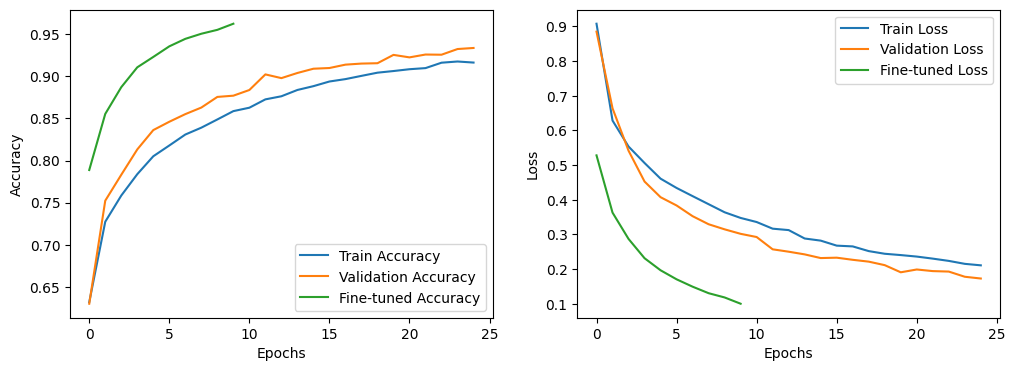

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Concatenate, Input
from tensorflow.keras.applications import DenseNet201, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

warnings.filterwarnings(action="ignore")

# Check for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available and enabled for TensorFlow")

# Define file directories and labels
MildDemented_dir = "content/AugmentedAlzheimerDataset/MildDemented"
ModerateDemented_dir = "content/AugmentedAlzheimerDataset/ModerateDemented"
NonDemented_dir = "content/AugmentedAlzheimerDataset/NonDemented"
VeryMildDemented_dir = "content/AugmentedAlzheimerDataset/VeryMildDemented"
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

# DataFrame of image paths and labels
filepaths, labels = [], []
for i, path in enumerate(dict_list):
    flist = os.listdir(path)
    for f in flist:
        filepaths.append(os.path.join(path, f))
        labels.append(class_labels[i])

Alzheimer_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
train_images, test_images = train_test_split(Alzheimer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(train_images, test_size=0.2, random_state=42)

# Image Data Generator
image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train = image_gen.flow_from_dataframe(train_set, x_col="filepaths", y_col="labels",
                                      target_size=(244, 244), class_mode="categorical", batch_size=128)
val = image_gen.flow_from_dataframe(val_set, x_col="filepaths", y_col="labels",
                                    target_size=(244, 244), class_mode="categorical", batch_size=128)
test = image_gen.flow_from_dataframe(test_images, x_col="filepaths", y_col="labels",
                                     target_size=(244, 244), class_mode="categorical", batch_size=128)

# Define the multi-branch model with DenseNet201 and VGG16 branches
input_shape = (244, 244, 3)
input_tensor = Input(shape=input_shape)

# DenseNet201 branch
densenet_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=input_tensor)
densenet_output = GlobalAveragePooling2D()(densenet_model.output)
densenet_output = BatchNormalization()(densenet_output)

# VGG16 branch
vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
vgg_output = GlobalAveragePooling2D()(vgg_model.output)
vgg_output = BatchNormalization()(vgg_output)

# Combine branches
combined = Concatenate()([densenet_output, vgg_output])
combined = Dense(1024, activation='relu')(combined)
combined = Dropout(0.5)(combined)
final_output = Dense(4, activation='softmax')(combined)

# Define and compile the model
model = Model(inputs=input_tensor, outputs=final_output)

# Freeze initial layers
for layer in densenet_model.layers:
    layer.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

# Learning rate decay schedule
initial_lr = 0.001
lr_schedule = ExponentialDecay(initial_lr, decay_steps=10000, decay_rate=0.96, staircase=True)
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

# Train the model
history = model.fit(train, epochs=25, validation_data=val, callbacks=[early_stopping, reduce_lr])

# Unfreeze all layers for fine-tuning
for layer in densenet_model.layers:
    layer.trainable = True
for layer in vgg_model.layers:
    layer.trainable = True

# Compile again with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine = model.fit(train, epochs=10, validation_data=val, callbacks=[early_stopping])

# Evaluation
test_loss, test_acc = model.evaluate(test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Save the model
model.save("hybrid_alzheimer_model.h5")

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
